# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
import pickle

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [4]:
tracks = pd.read_parquet("tracks.parquet")
interactions = pd.read_parquet("interactions.parquet")
cat_names = pd.read_parquet("catalog_names.parquet")

# Обзор данных

Посмотрим на данные, их количество и возможные проблемы. 

In [5]:
print(tracks.info())
tracks.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB
None


,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [6]:
print(interactions.info())
interactions.head()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB
None


,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [7]:
interactions.track_id.nunique()

1000000

In [10]:
print(cat_names.info())
cat_names.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB
None


,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [11]:
cat_names.type.value_counts()

type
track     1000000
album      658724
artist     153581
genre         166
Name: count, dtype: int64

In [13]:
cat_names.query("type == 'genre'").head()

,id,type,name
812305,0,genre,all
812306,1,genre,eastern
812307,2,genre,rusrock
812308,3,genre,rusrap
812309,4,genre,postrock


Посчитаем какое количество пользователей прослушало наименее популярные треки.

In [14]:
interactions.groupby("track_id").agg({"user_id": "count"}).sort_values(
    by="user_id"
).head()

,user_id
track_id,
42572290,5
29705249,5
29706278,5
29706418,5
29706809,5


Посмотрим как распределяется количество треков прослушанных каждым пользователем.

In [15]:
interactions.groupby("user_id").agg({"track_id": "count"}).sort_values(
    by="track_id"
).describe()

,track_id
count,1.373221e+06
mean,1.621224e+02
std,3.512846e+02
min,1.000000e+00
25%,2.300000e+01
50%,5.500000e+01
75%,1.540000e+02
max,1.663700e+04


Заметен большой разброс в пользователях из наших данных - некоторые прослушали всего по одному треку, а также есть пользователи у которых в истории взаимодействия более 16тыс. прослушанных треков.

Оставим данные только о пользователям прослушавших от 6ти до 350ти треков.

In [16]:
top_users = (
    interactions.groupby("user_id")
    .agg({"track_id": "count"})
    .sort_values(by="track_id")
    .reset_index()
)
top_users = top_users[(top_users.track_id > 5) & (top_users.track_id < 350)]

In [17]:
interactions = interactions[interactions.user_id.isin(top_users.user_id)]
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93408782 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 2.3 GB


Посмотрим какое максимальное количество жанров может содержать один трек

In [21]:
max(len(x) for x in tracks.genres)

10

Теперь в какое максимальное количество альбомов может входить один трек

In [24]:
max(len(x) for x in tracks.albums)

2844

И какое максимальное количество исполнителей может содержать один трек

In [25]:
max(len(x) for x in tracks.artists)

26

Оставим в информации о треках только первые 2 исполнителя, 2 альбома и 2 жанра для упрощения. И разнесем их на разные колонки

In [20]:
tracks_info = tracks.copy()
for col in tracks.columns[1:]:
    df = pd.Series([x[:2] for x in tracks[col]], index=tracks.track_id)
    df = pd.DataFrame(df.values.tolist(), index=df.index).add_prefix(f"{col}_")
    tracks_info = tracks_info.merge(
        df, left_on="track_id", right_on=df.index, how="left"
    )


tracks_info.head()


,track_id,albums,artists,genres,albums_0,albums_1,artists_0,artists_1,genres_0,genres_1
0,26,"[3, 2490753]",[16],"[11, 21]",3.0,2490753.0,16.0,NaN,11.0,21.0
1,38,"[3, 2490753]",[16],"[11, 21]",3.0,2490753.0,16.0,NaN,11.0,21.0
2,135,"[12, 214, 2490809]",[84],[11],12.0,214.0,84.0,NaN,11.0,NaN
3,136,"[12, 214, 2490809]",[84],[11],12.0,214.0,84.0,NaN,11.0,NaN
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],12.0,214.0,84.0,NaN,11.0,NaN


Внимательно посмотрим на часть таблицы `cat_names` с дополнительной информацией.

In [22]:
cat_names.query("id == 5")

,id,type,name
658725,5,artist,Max Roach
812310,5,genre,ukrrock


В данной таблице столбец `id` отвечает за идентификатор того типа информации, которая обозначена в графе `type` и поэтому в столбце `id` присутствуют повторы.

Добавим информацию о названиях треков, альбомов, жанров и исполнителей в таблицу `tracks_info`

Сначала добавим альбомы, жанры и исполнителей

In [29]:
for type in cat_names.type.unique()[:-1]:
    tracks_info = tracks_info.merge(
        cat_names.query("type == @type")[["id", "name"]],
        left_on=f"{type}s_0",
        right_on="id",
        how="left",
    )
    tracks_info = tracks_info.merge(
        cat_names.query("type == @type")[["id", "name"]],
        left_on=f"{type}s_1",
        right_on="id",
        how="left",
        suffixes=(f"_{type}_1", f"_{type}_2"),
    )

tracks_info.head()

,track_id,albums,artists,genres,albums_0,albums_1,artists_0,artists_1,genres_0,genres_1,...,id_album_2,name_album_2,id_artist_1,name_artist_1,id_artist_2,name_artist_2,id_genre_1,name_genre_1,id_genre_2,name_genre_2
0,26,"[3, 2490753]",[16],"[11, 21]",3.0,2490753.0,16.0,NaN,11.0,21.0,...,2490753.0,Taller Children,16.0,Elizabeth & the Catapult,NaN,NaN,11.0,pop,21.0,folk
1,38,"[3, 2490753]",[16],"[11, 21]",3.0,2490753.0,16.0,NaN,11.0,21.0,...,2490753.0,Taller Children,16.0,Elizabeth & the Catapult,NaN,NaN,11.0,pop,21.0,folk
2,135,"[12, 214, 2490809]",[84],[11],12.0,214.0,84.0,NaN,11.0,NaN,...,214.0,Wild Young Hearts,84.0,Noisettes,NaN,NaN,11.0,pop,NaN,NaN
3,136,"[12, 214, 2490809]",[84],[11],12.0,214.0,84.0,NaN,11.0,NaN,...,214.0,Wild Young Hearts,84.0,Noisettes,NaN,NaN,11.0,pop,NaN,NaN
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],12.0,214.0,84.0,NaN,11.0,NaN,...,214.0,Wild Young Hearts,84.0,Noisettes,NaN,NaN,11.0,pop,NaN,NaN


Затем добавим названия треков

In [30]:
tracks_info = tracks_info.merge(
    cat_names.query("type == 'track'")[["id", "name"]],
    left_on="track_id",
    right_on="id",
    how="left",
)

tracks_info = tracks_info.rename(columns={"id": "id_track", "name": "name_track"})

Удалим повторяющуюся информацию и переведем тип некоторых данных

In [33]:
items = tracks_info.iloc[:, 10:]
items[items.select_dtypes("float64").columns] = items.select_dtypes("float64").astype(
    "Int32"
)

In [34]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   id_album_1     999982 non-null   Int32 
 1   name_album_1   999982 non-null   object
 2   id_album_2     319008 non-null   Int32 
 3   name_album_2   319008 non-null   object
 4   id_artist_1    984631 non-null   Int32 
 5   name_artist_1  984631 non-null   object
 6   id_artist_2    200970 non-null   Int32 
 7   name_artist_2  200970 non-null   object
 8   id_genre_1     996306 non-null   Int32 
 9   name_genre_1   996306 non-null   object
 10  id_genre_2     570737 non-null   Int32 
 11  name_genre_2   570737 non-null   object
 12  id_track       1000000 non-null  int64 
 13  name_track     1000000 non-null  object
dtypes: Int32(6), int64(1), object(7)
memory usage: 89.6+ MB


In [36]:
# interactions.to_parquet("interactions_next.parquet")
# items.to_parquet("tracks_next.parquet")

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

Мы получили три файла с данными: `tracks`, `catalog_names`, `interactions`. 

Первый файл `tracks` - информация о 1 млн треков, с названием трека, жанрами, исполнителями и альбомами, все данные в цифровом закодированном формате. У одного трека может быть одно название, но колонки с жанром, альбомом и исполнителем содержат список из одного или нескольких значений.<br>
Второй файл `catalog_names` содержит вспомогательную информацию о треках, в файле перемешаны цифровые id и истинные названия треков, жанров, исполнителей и альбомов. Для каждого id выставлен тип, по которому можно ориентироваться, что за информацию несет строка данных. Содержит всего 1_812_471 записей <br>
В третьем файле `interactions` содержится информация о том какие пользователи прослушали какие треки + временные метки этих прослушиваний. Содержатся записи за 1 год. При этом записи не учитывают повторные прослушивания. Информация о прослушивании охватывает весь миллион треков, информацию о которых мы имеем. Всего 222_629_898 записей.

На данном этапе были произведены следующие преобразования:
- в файле `tracks` оставлена только информация о первых двух записях в колонках с жанром, альбомом и исполнителем у каждого трека;
- из файла `catalog_names` в файл `tracks` добавлена информация о названии треков, жанров, альбомов и исполнителей и сохранено в файл `items`;
- в файле `interactions` оставлены только записи для пользователей прослушавших от 5 до 350 треков за всю историю взаимодействия.

In [1]:
%reset -f

# === ЭТАП 2 ===

In [8]:
# events = pd.read_parquet("interactions_next.parquet")
# tracks = pd.read_parquet("tracks_next.parquet")

# EDA

##### Распределение количества прослушанных треков в целом и по месяцам.

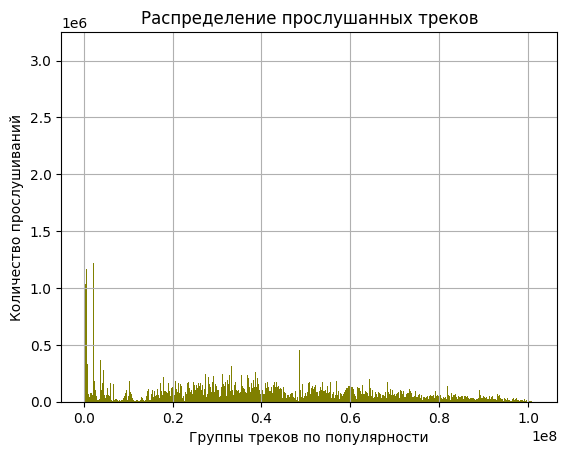

In [14]:
events.track_id.hist(bins=1000, color="olive")
plt.xlabel("Группы треков по популярности")
plt.ylabel("Количество прослушиваний")
plt.title("Распределение прослушанных треков")
plt.show()

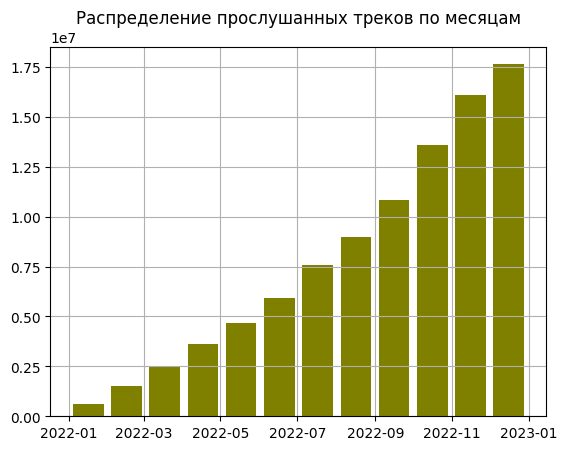

In [10]:
events.started_at.hist(bins=12, color="olive", rwidth=0.8)
plt.title("Распределение прослушанных треков по месяцам")
plt.show()

По графикам видно, что среди всех треков, всего малая часть пользуется огромной популярностью у пользователей, остальные треки имеют довольно равномерное количество прослушиваний.
При этом график ежемесячного прослушивания показывает увеличение активности пользователей с каждым следующим месяцем в течении года.

##### Наиболее популярные треки

In [138]:
top_tracks = (
    events.groupby(by="track_id")
    .agg({"user_id": "count"})
    .sort_values(by="user_id", ascending=False)
)
top_tracks = top_tracks.rename(columns={"user_id": "counts"})
top_tracks = top_tracks.merge(
    tracks[["id_track", "name_track", "name_artist_1"]],
    left_on=top_tracks.index,
    right_on="id_track",
    how="left",
)
top_tracks[:10]

,counts,id_track,name_track,name_artist_1
0,70582,33311009,Believer,Imagine Dragons
1,69608,35505245,I Got Love,Miyagi & Эндшпиль
2,64978,53404,Smells Like Teen Spirit,Nirvana
3,61069,65851540,Юность,Dabro
4,60844,178529,Numb,Linkin Park
5,60806,45499814,Life,Zivert
6,59654,32947997,Shape of You,Ed Sheeran
7,55278,39257277,In My Mind,Dynoro
8,54741,49961817,Грустный дэнс,Artik & Asti
9,54621,51241318,In The End,Tommee Profitt


##### Наиболее популярные жанры

In [139]:
top_tracks = top_tracks.merge(
    tracks[["id_track", "name_genre_1", "name_genre_2"]], on="id_track", how="left"
)
top_tracks

,counts,id_track,name_track,name_artist_1,name_genre_1,name_genre_2
0,70582,33311009,Believer,Imagine Dragons,rock,allrock
1,69608,35505245,I Got Love,Miyagi & Эндшпиль,rusrap,rap
2,64978,53404,Smells Like Teen Spirit,Nirvana,alternative,rock
3,61069,65851540,Юность,Dabro,pop,ruspop
4,60844,178529,Numb,Linkin Park,numetal,metal
...,...,...,...,...,...,...
963541,1,101308446,Засыпай,ДжиАш,pop,ruspop
963542,1,802,"Rock, Rock, Rock",Sparks,pop,rock
963543,1,806,Metaphor,Sparks,pop,rock
963544,1,101308694,Let You Go,Ry X,indie,None


In [140]:
top_genres = top_tracks.groupby(by="name_genre_1").agg(genre_1_votes=("counts", "sum"))
top_genres = top_genres.merge(
    top_tracks.groupby(by="name_genre_2").agg(genre_2_votes=("counts", "sum")),
    left_index=True,
    right_index=True,
    how="left",
)
top_genres["sum_votes"] = top_genres.genre_1_votes + top_genres.genre_2_votes
top_genres = top_genres.sort_values(by="sum_votes", ascending=False)


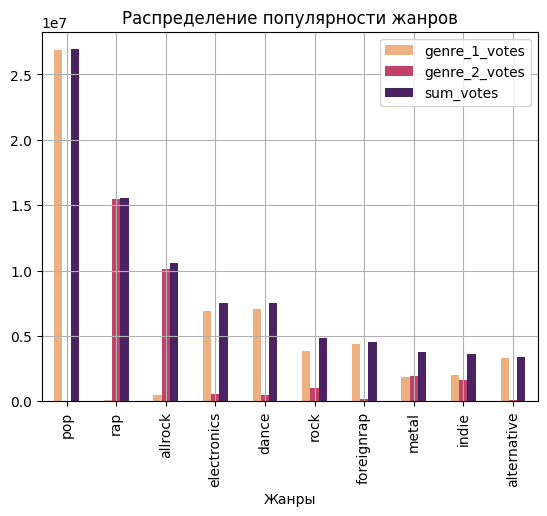

In [141]:
top_genres[:10].plot(
    kind="bar",
    title="Распределение популярности жанров",
    xlabel="Жанры",
    grid=True,
    colormap="flare",
)
plt.show()

"Pop" на то и "pop", чтобы быть самым популярным жанром, с отрывом от остальных. Вторым по популярности является rap, но его основная популярность находится в тех треках, где он является вторым жанром.

##### Количество треков, не вошедших в таблицу с прослушиваниями.

In [146]:
print("Количество треков, которые не попали в таблицу взаимодействий:")
tracks.shape[0] - events.track_id.nunique()

Количество треков, которые не попали в таблицу взаимодействий:


36454

36.5 тыс. треков, которые не попали в наши расчеты из-за фильтрации по пользователям. Это примерно 3.7% от всех имеющихся треков.

##### Распределение суммарного количества треков в очереди пользователей

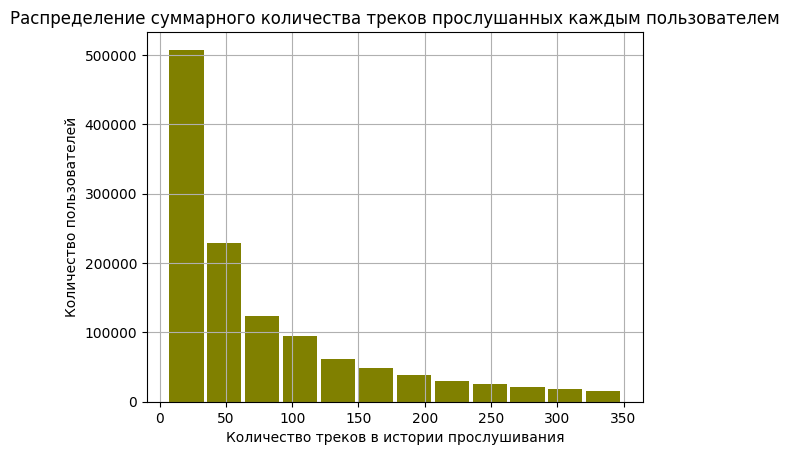

In [15]:
events.groupby(by="user_id").agg({"track_id": "count"}).hist(
    bins=12, color="olive", rwidth=0.9
)
plt.xlabel("Количество треков в истории прослушивания")
plt.ylabel("Количество пользователей")
plt.title(
    "Распределение суммарного количества треков прослушанных каждым пользователем"
);

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

Для этого перекодируем идентификаторы пользователей и треков в последовательность 0, 1, 2 ...

In [16]:
tracks = tracks.rename(columns={"id_track": "track_id"})

In [17]:
user_encoder = sklearn.preprocessing.LabelEncoder()
events["user_id"] = user_encoder.fit_transform(events["user_id"])

item_encoder = sklearn.preprocessing.LabelEncoder()
tracks["track_id"] = item_encoder.fit_transform(tracks["track_id"])
events["track_id"] = item_encoder.transform(events["track_id"])

# Сохранение данных

Сохраним данные и добавимих в персональное хранилище (S3-бакет) по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [18]:
events.to_parquet("events.parquet")
tracks.to_parquet("items.parquet")

with open("user_encoder.pkl", "wb") as f:
    pickle.dump(user_encoder, f)

with open("item_encoder.pkl", "wb") as f:
    pickle.dump(item_encoder, f)

In [3]:
import boto3
import os
from dotenv import load_dotenv

load_dotenv()


def get_session_student():
    session = boto3.session.Session()

    return session.client(
        service_name="s3",
        endpoint_url=os.getenv("S3_ENDPOINT_URL"),
        aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
        aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    )


s3 = get_session_student()
bucket_name = os.getenv("S3_BUCKET_NAME")

s3.upload_file("items.parquet", bucket_name, "recsys/data/items.parquet")
s3.upload_file("events.parquet", bucket_name, "recsys/data/events.parquet")

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Перезапустить kernel

In [3]:
%reset -f

Код для удаление более ненужных переменных

In [2]:
import gc

gc.collect()

512

# === ЭТАП 3 ===

# Загрузка данных

Если ядро было перезагружено, то загружаем items.parquet, events.parquet и обученые энкодеры user_encoder.pkl, item_encoder.pkl

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from implicit.als import AlternatingLeastSquares
import pickle
from catboost import CatBoostClassifier, Pool

SEED = 777

In [6]:
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

In [7]:
with open("user_encoder.pkl", "rb") as f:
    user_encoder = pickle.load(f)

with open("item_encoder.pkl", "rb") as f:
    item_encoder = pickle.load(f)

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [4]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93408782 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int64         
 1   track_id    int64         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int64(2)
memory usage: 3.0 GB


In [7]:
split_date = pd.to_datetime("2022-12-16").to_datetime64()

train_test_split_idx = events["started_at"] < split_date
events_train = events[train_test_split_idx]
events_test = events[~train_test_split_idx]

# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
# количество пользователей, которые есть и в train, и в test
common_users = set(users_train).intersection(set(users_test))

print(len(users_train), len(users_test), len(common_users))

1183753 684894 654417


# Топ популярных

Рассчитаем рекомендации как топ популярных треков по количество пользователей прослушавших трек.

In [7]:
top_100_items = (
    events_train.groupby(by="track_id")
    .agg({"user_id": "count"})
    .sort_values(by="user_id", ascending=False)
)[:100]
top_100_items = top_100_items.rename(columns={"user_id": "counts"})
top_100_items = top_100_items.merge(
    items[["track_id", "name_track", "name_artist_1", "name_genre_1"]],
    left_on=top_100_items.index,
    right_on="track_id",
    how="left",
)
top_100_items[:10]

,counts,track_id,name_track,name_artist_1,name_genre_1
0,65808,512157,I Got Love,Miyagi & Эндшпиль,rusrap
1,65101,483876,Believer,Imagine Dragons,rock
2,63942,9098,Smells Like Teen Spirit,Nirvana,alternative
3,59786,26665,Numb,Linkin Park,numetal
4,55230,647237,Life,Zivert,pop
5,54302,475289,Shape of You,Ed Sheeran,pop
6,52731,829320,Юность,Dabro,pop
7,50819,571352,In My Mind,Dynoro,dance
8,50217,90461,Shape Of My Heart,Sting,pop
9,50175,368072,Way Down We Go,KALEO,indie


In [8]:
top_popular = top_100_items[
    ["counts", "track_id", "name_track", "name_artist_1", "name_genre_1"]
].rename(columns={"track_id": "item_id"})
top_popular.to_parquet("top_popular.parquet")

# Персональные

Рассчитаем персональные рекомендации.

Cоздаём sparse-матрицу формата CSR с помощью столбцов `user_id` и `item_id`, на пересечении будет находиться информация о том, прослушал пользователь данный трек или нет.

In [62]:
events_train["listened"] = 1

/tmp/ipykernel_1757/3723997523.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["listened"] = 1


In [66]:
user_item_matrix_train = scipy.sparse.csr_matrix(
    (events_train["listened"], (events_train["user_id"], events_train["track_id"])),
    dtype=np.int8,
)

In [67]:
import sys

sum([sys.getsizeof(i) for i in user_item_matrix_train.data]) / 1024**3

1.97923902887851

Обучим ALS модель 

In [70]:
als_model = AlternatingLeastSquares(
    factors=30, iterations=50, regularization=0.05, random_state=SEED
)
als_model.fit(user_item_matrix_train)

/home/mle-user/mle-sprint4/env_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 50/50 [17:52<00:00, 21.44s/it]


Напишем функцию для получения рекомендаций для всех пользователей.

In [73]:
def get_recommendations_als(user_item_matrix, model, user_id, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    recommendations = model.recommend(
        user_id,
        user_item_matrix[user_id],
        filter_already_liked_items=not include_seen,
        N=n,
    )
    recommendations = pd.DataFrame(
        {"track_id": recommendations[0], "score": recommendations[1]}
    )
    recommendations = recommendations.merge(
        items[["track_id", "name_track", "name_artist_1", "name_genre_1"]],
        on="track_id",
        how="left",
    )

    return recommendations

Прежде чем запускать получение рекомендация попробуем "глазами" оценить работу рекомендательной модели, например для пользователя с `user_id = 45`

Посмотрим какие треки успел прослушать данный пользователь

In [116]:
events_train.query("user_id == 45").merge(
    items[["track_id", "name_track", "name_artist_1", "name_genre_1"]],
    on="track_id",
    how="left",
)

,user_id,track_id,track_seq,started_at,listened,name_track,name_artist_1,name_genre_1
0,45,405758,1,2022-02-18,1,Ты словно целая вселенная,Jah Khalib,rusrap
1,45,405762,2,2022-03-08,1,Сжигая дотла,Jah Khalib,rusrap
2,45,446959,3,2022-04-25,1,Санавабич,Miyagi & Эндшпиль,rusrap
3,45,454249,4,2022-06-16,1,"Если чё, я Баха",Jah Khalib,rusrap
4,45,454250,5,2022-07-01,1,ПОРваНо Платье,Jah Khalib,rusrap
5,45,454252,6,2022-07-26,1,Лейла,Jah Khalib,rusrap
6,45,454256,7,2022-08-19,1,Тату на твоём теле,Jah Khalib,rusrap
7,45,454257,8,2022-08-24,1,Созвездие Ангела,Jah Khalib,rusrap
8,45,454260,9,2022-09-08,1,Кружимся в танце,Jah Khalib,rusrap
9,45,454265,10,2022-09-15,1,Любимец твоих дьяволов,Jah Khalib,rusrap


Теперь посмотрим на рекомендации 5ти треков

In [117]:
get_recommendations_als(
    user_item_matrix_train, als_model, user_id=45, include_seen=True, n=5
)

,track_id,score,name_track,name_artist_1,name_genre_1
0,512157,0.135691,I Got Love,Miyagi & Эндшпиль,rusrap
1,423054,0.071590,Рапапам,9 грамм,rusrap
2,454252,0.052926,Лейла,Jah Khalib,rusrap
3,572585,0.050209,Пустите меня на танцпол,HammAli & Navai,rusrap
4,398379,0.042393,Капкан,MOT,rusrap


Рекомендации выглядят весьма правдоподобно.

Получаем рекомендации для всех пользователей

In [120]:
user_ids = range(len(user_encoder.classes_))

als_recommendations = als_model.recommend(
    user_ids, user_item_matrix_train[user_ids], filter_already_liked_items=False, N=50
)

Преобразуем полученные рекомендации в табличный формат

In [122]:
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame(
    {
        "user_id_enc": user_ids,
        "item_id_enc": item_ids_enc.tolist(),
        "score": als_scores.tolist(),
    }
)
als_recommendations = als_recommendations.explode(
    ["item_id_enc", "score"], ignore_index=True
)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(
    als_recommendations["user_id_enc"]
)
als_recommendations["item_id"] = item_encoder.inverse_transform(
    als_recommendations["item_id_enc"]
)
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

Сохраняем рекомендации в файл

In [36]:
als_recommendations = als_recommendations[["user_id", "item_id", "score"]]
als_recommendations.to_parquet("personal_als.parquet")

# Похожие

Рассчитаем похожие треки, они позже пригодятся для онлайн-рекомендаций.

In [124]:
item_ids = range(len(item_encoder.classes_))

Получим первые 10 похожих треков для каждого.

In [129]:
i2i_recommendations = als_model.similar_items(item_ids, N=10)

In [130]:
i2i_ids_enc = i2i_recommendations[0]
i2i_scores = i2i_recommendations[1]

i2i_recommendations = pd.DataFrame(
    {
        "item_id_enc": item_ids,
        "item_id_rec_enc": i2i_ids_enc.tolist(),
        "score_i2i": i2i_scores.tolist(),
    }
)
i2i_recommendations = i2i_recommendations.explode(
    ["item_id_rec_enc", "score_i2i"], ignore_index=True
)

# приводим типы данных
i2i_recommendations["item_id_rec_enc"] = i2i_recommendations["item_id_rec_enc"].astype(
    "int"
)
i2i_recommendations["item_id_enc"] = i2i_recommendations["item_id_enc"].astype("int")
i2i_recommendations["score_i2i"] = i2i_recommendations["score_i2i"].astype("float")

# получаем изначальные идентификаторы
i2i_recommendations["item_id_rec"] = item_encoder.inverse_transform(
    i2i_recommendations["item_id_rec_enc"]
)
i2i_recommendations["item_id"] = item_encoder.inverse_transform(
    i2i_recommendations["item_id_enc"]
)
i2i_recommendations = i2i_recommendations.drop(
    columns=["item_id_rec_enc", "item_id_enc"]
)

In [45]:
i2i_recommendations.head(12)

,item_id_rec,item_id,score_i2i
1,220496,26,0.979759
2,305077,26,0.975196
3,23873956,26,0.974571
4,30510073,26,0.971379
5,126860,26,0.969608
6,1481212,26,0.967037
7,16780420,26,0.965344
8,965,26,0.962603
9,18372115,26,0.962505
11,17953872,38,0.943089


Тоже сохраним в файл

In [44]:
i2i_recommendations = i2i_recommendations.query("item_id_rec != item_id")[
    ["item_id_rec", "item_id", "score_i2i"]
]
i2i_recommendations.to_parquet("similar.parquet")

# Построение признаков

Далее соберем несколько вспомогательных признаков к рекомендациям ALS, чтобы на основе этого обучить ранжирующую модель.

Для ранжирующей модели разделим тестовую выборку на 2 части - для обучения ранж. модели и для ее тестирования

In [8]:
split_date_for_range = pd.to_datetime("2022-12-22").to_datetime64()

split_date_for_range_idx = events_test["started_at"] < split_date_for_range
events_labels = events_test[split_date_for_range_idx].copy()
events_test_2 = events_test[~split_date_for_range_idx].copy()
events_labels.user_id.nunique(), events_test_2.user_id.nunique()

(561289, 555675)

In [10]:
personal_als = pd.read_parquet("personal_als.parquet")

Вернем рекомендациям кодировку при которой id треков и пользователей будут совпадать с id в файлах `events_*`

In [11]:
personal_als["user_id"] = user_encoder.transform(personal_als["user_id"]).astype(
    "int32"
)
personal_als["item_id"] = item_encoder.transform(personal_als["item_id"]).astype(
    "int32"
)
personal_als

,user_id,item_id,score
0,0,384646,0.011107
1,0,423544,0.010649
2,0,398379,0.010103
3,0,384240,0.009582
4,0,60200,0.009286
...,...,...,...
60711495,1214229,595403,0.128652
60711496,1214229,848374,0.128601
60711497,1214229,754040,0.125561
60711498,1214229,848373,0.125505


Для ранжирующей модели оставим в обучающем наборе только тех пользователей, которые также появились в наборе данных `events_labels`, с помощью которого мы будем размечать `target`.


In [12]:
candidates = personal_als[
    personal_als["user_id"].isin(events_labels["user_id"].unique())
].copy()

Теперь начнем добавлять признаки к файлу с рекомендациями. Первым признаком добавим колонку `track_seq` из начального датасета

In [13]:
candidates = candidates.merge(
    events_train[["user_id", "track_id", "track_seq"]].rename(
        columns={"track_id": "item_id"}
    ),
    on=["user_id", "item_id"],
    how="left",
)

Затем из файла с информацией о треках подтянем каждой рекомендации название исполнителя и названия 2х первых жанров в цифровом виде.

In [16]:
candidates = candidates.merge(
    items[["track_id", "id_genre_1", "id_genre_2", "id_artist_1"]].rename(
        columns={"track_id": "item_id"}
    ),
    on="item_id",
    how="left",
)

Промежуточный результат выглядит следующим образом:

In [17]:
candidates

,user_id,item_id,score,track_seq,id_genre_1,id_genre_2,id_artist_1
0,3,512157,0.704016,14.0,3,75,4611844
1,3,647237,0.442222,NaN,11,20,5007577
2,3,483876,0.377078,NaN,14,102,675068
3,3,682662,0.353102,22.0,11,20,666984
4,3,579622,0.346174,NaN,11,20,5007577
...,...,...,...,...,...,...,...
28064445,1214229,595403,0.128652,NaN,11,20,3827925
28064446,1214229,848374,0.128601,NaN,3,75,6774682
28064447,1214229,754040,0.125561,NaN,12,<NA>,2395501
28064448,1214229,848373,0.125505,160.0,3,75,6774682


Теперь добавим также информацию о количестве прослушиваний для рекомендуемого трека. В качестве голосов - будем учитывать количество пользователей, которые прослушали трек в обучающем датасете.

In [31]:
tracks_votes = (
    events_train.groupby(by="track_id")
    .agg({"user_id": "count"})
    .reset_index()
    .rename(columns={"user_id": "votes", "track_id": "item_id"})
)

In [34]:
candidates = candidates.merge(tracks_votes, on="item_id", how="left")

И в качестве последнего признака добавим информацию о пользователе. Добавим пользователям количество прослушанных треков за период, которых охватывают тренировочные данные.

In [10]:
tracks_count = (
    events_train.groupby("user_id")
    .agg({"track_id": "count"})
    .reset_index()
    .rename(columns={"track_id": "tracks_count"})
)

In [12]:
candidates = candidates.merge(tracks_count, on=["user_id"], how="left")


Финальная версия вылядит следующим образом:

In [13]:
candidates

,user_id,item_id,score,track_seq,id_genre_1,id_genre_2,id_artist_1,votes,tracks_count
0,3,512157,0.704016,14.0,3,75,4611844,65808,32.0
1,3,647237,0.442222,NaN,11,20,5007577,55230,32.0
2,3,483876,0.377078,NaN,14,102,675068,65101,32.0
3,3,682662,0.353102,22.0,11,20,666984,49380,32.0
4,3,579622,0.346174,NaN,11,20,5007577,45000,32.0
...,...,...,...,...,...,...,...,...,...
28064445,1214229,595403,0.128652,NaN,11,20,3827925,13809,207.0
28064446,1214229,848374,0.128601,NaN,3,75,6774682,26097,207.0
28064447,1214229,754040,0.125561,NaN,12,<NA>,2395501,9129,207.0
28064448,1214229,848373,0.125505,160.0,3,75,6774682,28898,207.0


In [ ]:
candidates.to_parquet("candidates.parquet")

In [ ]:
# candidates = pd.read_parquet("candidates.parquet")

Для обучающей разметки будем использовать часть данных `events_labels`, все взаимодействия из фанного файла будут считаться желаемой целью обучения.

In [16]:
events_labels["target"] = 1
candidates = candidates.merge(
    events_labels[["user_id", "track_id", "target"]].rename(
        columns={"track_id": "item_id"}
    ),
    on=["user_id", "item_id"],
    how="left",
)
candidates["target"] = candidates["target"].fillna(0).astype("int")

Взглянем на соотношение классов в полученном датасете

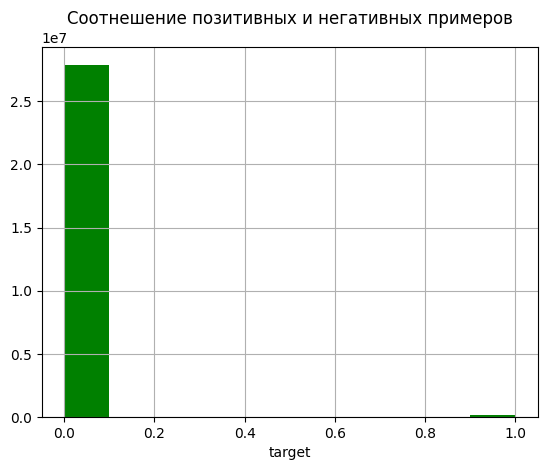

In [20]:
candidates["target"].hist(color="g")
plt.title("Соотнешение позитивных и негативных примеров")
plt.xlabel("target");

Мы получили довольно сильный дисбалланс классов, так как рекомендации дают сразу по 50 треков для каждого пользователя.

Для некоторого уравнивания классов оставим только 4 негативных примера для каждого пользователя.

In [22]:
candidates_positive = candidates.groupby("user_id").filter(
    lambda x: x["target"].sum() > 0
)

negatives_per_user = 4
candidates_for_train = pd.concat(
    [
        candidates_positive.query("target == 1"),
        candidates_positive.query("target == 0")
        .groupby("user_id")
        .apply(lambda x: x.sample(negatives_per_user, random_state=0)),
    ]
)
candidates_for_train.shape

(5028000, 10)

Отлично. Теперь для корректной работы модели заполним все пропуски в данных нулями

In [34]:
candidates_for_train.track_seq = candidates_for_train.track_seq.fillna(0)

In [36]:
candidates_for_train.id_genre_2 = candidates_for_train.id_genre_2.fillna(0)

# Ранжирование рекомендаций

### Обучение модели

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Для ранжирования будем использовать модель CatBoostClassifier. Данные стандартизировать не будем, модель это допускает.

In [38]:
features = [
    "score",
    "track_seq",
    "id_genre_1",
    "id_genre_2",
    "id_artist_1",
    "votes",
    "tracks_count",
]
target = "target"

train_data = Pool(
    data=candidates_for_train[features], label=candidates_for_train[target]
)

cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=5,
    loss_function="Logloss",
    verbose=100,
    random_seed=SEED,
)

cb_model.fit(train_data)

0:	learn: 0.6291357	total: 104ms	remaining: 1m 43s
100:	learn: 0.4997552	total: 4.52s	remaining: 40.3s
200:	learn: 0.4868184	total: 9.02s	remaining: 35.8s
300:	learn: 0.4796379	total: 13.5s	remaining: 31.4s
400:	learn: 0.4743833	total: 18s	remaining: 26.9s
500:	learn: 0.4704767	total: 22.5s	remaining: 22.4s
600:	learn: 0.4673811	total: 27s	remaining: 17.9s
700:	learn: 0.4649119	total: 31.4s	remaining: 13.4s
800:	learn: 0.4626428	total: 35.9s	remaining: 8.92s
900:	learn: 0.4606494	total: 40.9s	remaining: 4.5s
999:	learn: 0.4590336	total: 45.6s	remaining: 0us


In [39]:
cb_model.save_model("model_recs")

### Подготовка данных для тестирования ранжирующей модели и расчета метрик

#### Подготовка ALS рекомендаций для инференса

Для правдоподобного тестирования ранжирующей модели подготовим свежие ALS рекомендации. Для этого переобучим ALS модель для персональных рекомендаций на основе данных и train выборки и из events_labels выборки.

In [9]:
events_infer = pd.concat([events_train, events_labels])
events_infer["target"] = 1

In [ ]:
user_item_matrix_infer = scipy.sparse.csr_matrix(
    (events_infer["target"], (events_infer["user_id"], events_infer["track_id"])),
    dtype=np.int8,
)

In [ ]:
import sys

sum([sys.getsizeof(i) for i in user_item_matrix_infer.data]) / 1024**3

2.065130858682096

In [ ]:
als_model_final = AlternatingLeastSquares(
    factors=30, iterations=50, regularization=0.05, random_state=SEED
)
als_model_final.fit(user_item_matrix_infer)

/home/mle-user/mle-sprint4/env_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
user_ids = range(len(user_encoder.classes_))

als_recommendations_infer = als_model_final.recommend(
    user_ids, user_item_matrix_infer[user_ids], filter_already_liked_items=False, N=50
)

In [ ]:
# преобразуем полученные рекомендации в табличный формат
item_ids = als_recommendations_infer[0]
als_scores = als_recommendations_infer[1]

als_recommendations_infer = pd.DataFrame(
    {
        "user_id": user_ids,
        "item_id": item_ids.tolist(),
        "score": als_scores.tolist(),
    }
)
als_recommendations_infer = als_recommendations_infer.explode(
    ["item_id", "score"], ignore_index=True
)

# приводим типы данных
als_recommendations_infer["item_id"] = als_recommendations_infer["item_id"].astype(
    "int"
)
als_recommendations_infer["score"] = als_recommendations_infer["score"].astype("float")


# als_recommendations_infer["user_id"] = user_encoder.inverse_transform(
#     als_recommendations_infer["user_id_enc"]
# )
# als_recommendations_infer["item_id"] = item_encoder.inverse_transform(
#     als_recommendations_infer["item_id_enc"]
# )
# als_recommendations_infer = als_recommendations_infer.drop(columns=["user_id_enc", "item_id_enc"])

In [ ]:
als_recommendations_infer = als_recommendations_infer[["user_id", "item_id", "score"]]
als_recommendations_infer.to_parquet("als_recommendations_infer.parquet")

#### Далее добавим к свежим рекомендациям теже признаки, которые мы добавляли для обучения ранжирующей модели

In [ ]:
candidates_for_infer = als_recommendations_infer[
    als_recommendations_infer["user_id"].isin(events_test_2["user_id"].unique())
].copy()

candidates_for_infer = candidates_for_infer.merge(
    events_infer[["user_id", "track_id", "track_seq"]].rename(
        columns={"track_id": "item_id"}
    ),
    on=["user_id", "item_id"],
    how="left",
)

In [ ]:
candidates_for_infer = candidates_for_infer.merge(
    items[["track_id", "id_genre_1", "id_genre_2", "id_artist_1"]].rename(
        columns={"track_id": "item_id"}
    ),
    on="item_id",
    how="left",
)

In [ ]:
candidates_for_infer

,user_id,item_id,score,track_seq,id_genre_1,id_genre_2,id_artist_1
0,4,79121,0.289590,NaN,59,102,191175
1,4,197265,0.256849,NaN,13,<NA>,36963
2,4,293729,0.236490,92.0,14,68,138028
3,4,77023,0.224774,NaN,59,102,191175
4,4,69303,0.219646,55.0,59,102,191175
...,...,...,...,...,...,...,...
27783745,1214229,572585,0.165861,NaN,3,75,5129397
27783746,1214229,894006,0.164053,NaN,16,<NA>,170642
27783747,1214229,850748,0.163497,162.0,11,20,8377409
27783748,1214229,973589,0.162849,NaN,11,20,161247


In [ ]:
tracks_votes = (
    events_infer.groupby(by="track_id")
    .agg({"user_id": "count"})
    .reset_index()
    .rename(columns={"user_id": "votes", "track_id": "item_id"})
)

In [ ]:
candidates_for_infer = candidates_for_infer.merge(
    tracks_votes, on="item_id", how="left"
)

In [ ]:
tracks_count = (
    events_infer.groupby("user_id")
    .agg({"track_id": "count"})
    .reset_index()
    .rename(columns={"track_id": "tracks_count"})
)

In [ ]:
candidates_for_infer = candidates_for_infer.merge(
    tracks_count, on=["user_id"], how="left"
)

In [ ]:
candidates_for_infer

,user_id,item_id,score,track_seq,id_genre_1,id_genre_2,id_artist_1,votes,tracks_count
0,4,79121,0.289590,NaN,59,102,191175,33023,248.0
1,4,197265,0.256849,NaN,13,<NA>,36963,45725,248.0
2,4,293729,0.236490,92.0,14,68,138028,22502,248.0
3,4,77023,0.224774,NaN,59,102,191175,21789,248.0
4,4,69303,0.219646,55.0,59,102,191175,20109,248.0
...,...,...,...,...,...,...,...,...,...
27783745,1214229,572585,0.165861,NaN,3,75,5129397,34642,243.0
27783746,1214229,894006,0.164053,NaN,16,<NA>,170642,14500,243.0
27783747,1214229,850748,0.163497,162.0,11,20,8377409,18026,243.0
27783748,1214229,973589,0.162849,NaN,11,20,161247,9370,243.0


In [15]:
candidates_for_infer.track_seq = candidates_for_infer.track_seq.fillna(0)

In [16]:
candidates_for_infer.id_genre_2 = candidates_for_infer.id_genre_2.fillna(0)

In [17]:
candidates_for_infer.id_genre_2.isna().sum()

0

In [18]:
candidates_for_infer.to_parquet("candidates_for_infer.parquet")

#### Теперь получим тестовые результаты от ранжирующей модели

In [25]:
cb_model = CatBoostClassifier()

cb_model.load_model("model_recs")

In [26]:
features = [
    "score",
    "track_seq",
    "id_genre_1",
    "id_genre_2",
    "id_artist_1",
    "votes",
    "tracks_count",
]

test_data = Pool(data=candidates_for_infer[features])
predictions = cb_model.predict_proba(test_data)

candidates_for_infer["cb_score"] = predictions[:, 1]

candidates_for_infer = candidates_for_infer.sort_values(
    ["user_id", "cb_score"], ascending=[True, False]
)
candidates_for_infer["rank"] = candidates_for_infer.groupby(by="user_id").cumcount() + 1

max_recommendations_per_user = 50
final_recommendations = candidates_for_infer[
    candidates_for_infer["rank"] <= max_recommendations_per_user
]


In [28]:
final_recommendations.head(8)

,user_id,item_id,score,track_seq,id_genre_1,id_genre_2,id_artist_1,votes,tracks_count,cb_score,rank
34,4,362532,0.109169,0.0,59,102,191175,7192,248.0,0.402743,1
39,4,362689,0.104161,0.0,59,102,191175,7283,248.0,0.402270,2
49,4,476,0.094991,0.0,11,0,2107,6539,248.0,0.356398,3
28,4,779281,0.118354,0.0,74,0,611169,45027,248.0,0.328629,4
41,4,62720,0.100948,0.0,14,102,57862,8224,248.0,0.277258,5
6,4,599686,0.180064,0.0,14,102,82972,16346,248.0,0.257097,6
32,4,19854,0.110021,0.0,14,102,41868,11114,248.0,0.152987,7
46,4,213075,0.096264,0.0,68,0,1433871,13451,248.0,0.142874,8


In [29]:
final_recommendations.to_parquet("recommendations.parquet")

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

### Функции для измерения метрик

Для разметки результатов рекомендаций ALS и общих рекомендаций.

In [12]:
def process_als_for_binary_metrics(data_train, data_test, recs, top_k=None):
    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    data_test["gt"] = True
    common_users = set(data_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")

    events_for_common_users = data_test[data_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(
        ["user_id", "score"], ascending=[True, False]
    )

    # оставляет только те item_id, которые были в train части
    events_for_common_users = events_for_common_users[
        events_for_common_users["track_id"].isin(data_train["track_id"].unique())
    ].rename(columns={"track_id": "item_id"})

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)

    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]],
        on=["user_id", "item_id"],
        how="outer",
    )

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()

    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

Для разметки результатов рекомендаций из топа треков для холодных пользователей

In [13]:
def process_top_for_binary_metrics(data_train, data_test, top_tracks, top_k=5):
    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """
    data_test["gt"] = True

    cold_users = set(data_test.user_id).difference(set(data_train.user_id))

    print(f"Cold users: {len(cold_users)}")

    events_for_cold_users = (
        data_test[data_test["user_id"].isin(cold_users)]
        .rename(columns={"track_id": "item_id"})
        .copy()
    )
    recs_top = list(top_tracks.item_id[:top_k])

    events_recs = pd.DataFrame(
        {
            "user_id": list(cold_users),
            "item_id": [recs_top for _ in range(len(cold_users))],
        },
    )
    events_recs = events_recs.explode("item_id")
    events_recs["pr"] = True

    events_for_cold_users = events_for_cold_users[["user_id", "item_id", "gt"]].merge(
        events_recs[["user_id", "item_id", "pr"]],
        on=["user_id", "item_id"],
        how="outer",
    )

    print(events_for_cold_users.shape)

    events_for_cold_users["gt"] = events_for_cold_users["gt"].fillna(False)
    events_for_cold_users["pr"] = events_for_cold_users["pr"].fillna(False)

    events_for_cold_users["tp"] = (
        events_for_cold_users["gt"] & events_for_cold_users["pr"]
    )
    events_for_cold_users["fp"] = (
        ~events_for_cold_users["gt"] & events_for_cold_users["pr"]
    )
    events_for_cold_users["fn"] = (
        events_for_cold_users["gt"] & ~events_for_cold_users["pr"]
    )

    return events_for_cold_users

Функция для расчета precision и recall, покрытие по пользователям (coverage) и novetly_top_n - то, какая часть рекомендация является новыми треками для пользователя.

In [14]:
def compute_cls_metrics(events_recs_for_binary_metric):
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision
    precision = groupper["tp"].sum() / (groupper["tp"].sum() + groupper["fp"].sum())
    precision = precision.fillna(0).mean()

    # recall
    recall = groupper["tp"].sum() / (groupper["tp"].sum() + groupper["fn"].sum())
    recall = recall.fillna(0).mean()
    return precision, recall

In [15]:
def coverage(data_test, recs):
    common = len(set(data_test["user_id"]) & set(recs["user_id"]))
    all_users = data_test.user_id.nunique()
    return common / all_users

In [11]:
def novetly_top_n(data_train, recs_with_score, top_n):
    data_train["listened"] = True
    data_train = data_train.rename(columns={"track_id": "item_id"})
    recs_with_score = recs_with_score.merge(
        data_train[["user_id", "item_id", "listened"]],
        on=["user_id", "item_id"],
        how="left",
    )
    recs_with_score["listened"] = (
        recs_with_score["listened"].fillna(False).astype("bool")
    )

    # проставим ранги
    recs_with_score = recs_with_score.sort_values(
        ["user_id", "score"], ascending=[True, False]
    )
    recs_with_score["rank"] = recs_with_score.groupby("user_id").cumcount() + 1

    # посчитаем novelty по пользователям
    fresh_tracks_mean = (
        recs_with_score.query("rank <= @top_n").groupby("user_id")["listened"].mean()
    )
    novelty_5 = 1 - fresh_tracks_mean

    # посчитаем средний novelty
    return np.mean(novelty_5)

### Расчет метрик

In [17]:
top_popular = pd.read_parquet("top_popular.parquet")
personal_als = pd.read_parquet("personal_als.parquet")
recommendations = pd.read_parquet("recommendations.parquet")

In [18]:
metrics = {}

Сначала добавим к рекомендациям разметку для подсчета метрик.

Период на котором мы оцениваем рекомендательные алгоритмы составляет не менее недели, а сами треки длятся в среднем около 4х минут - для оценки возьмем первые 15 рекомендаций

In [19]:
personal_als_markered = process_als_for_binary_metrics(
    events_train, events_test, personal_als, 15
)

recommendations_markered = process_als_for_binary_metrics(
    events_infer, events_test_2, recommendations, 15
)

top_binary_markered = process_top_for_binary_metrics(
    events_train, events_test, top_popular, 15
)

/tmp/ipykernel_20180/1389674443.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["gt"] = True


Common users: 605007
Common users: 555675


/tmp/ipykernel_20180/2817852776.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["gt"] = True


Cold users: 30477
(1544874, 4)


In [20]:
recs = {
    "als_cleen": personal_als_markered,
    "final_recs": recommendations_markered,
    "top_recs": top_binary_markered,
}

Посчитаем precision@15 и recall@15 для рекомендаций всех видов

In [21]:
for key in recs.keys():
    metrics[key] = {}
    metrics[key]["precision15"], metrics[key]["recall15"] = compute_cls_metrics(
        recs[key]
    )

In [22]:
metrics

{'als_cleen': {'precision15': 3.5261300006997165e-06,
  'recall15': 2.2446442079602787e-06},
 'final_recs': {'precision15': 0.006428697829966557,
  'recall15': 0.020478206878894255},
 'top_recs': {'precision15': 0.030875742363093477,
  'recall15': 0.014451030660861118}}

Посчитаем coverage - покрытие по пользователям - какую часть пользователей из тестовой выборки покрывают наши рекомендации.

In [23]:
metrics["als_cleen"]["coverage"] = coverage(events_test, personal_als_markered)
metrics["final_recs"]["coverage"] = coverage(events_test_2, recommendations_markered)
metrics["top_recs"]["coverage"] = 1


Посчитаем метрику novetly@15 - которая покажет, какую часть рекомендованных треков пользователь уже слышал.

In [14]:
metrics["als_cleen"]["novetly_top_15"] = novetly_top_n(
    events_train, personal_als_markered, 15
)
metrics["final_recs"]["novetly_top_15"] = novetly_top_n(
    events_infer, recommendations_markered, 15
)
metrics["top_recs"]["novetly_top_15"] = 1

/tmp/ipykernel_20846/1962877312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train["listened"] = True


In [16]:
import json

with open("metrics.json", "w") as fd:
    json.dump(metrics, fd)

In [17]:
metrics = pd.DataFrame([i for i in list(metrics.values())], index=metrics.keys())
metrics

,precision15,recall15,coverage,novetly_top_15
als_cleen,0.000004,0.000002,0.883359,0.999946
final_recs,0.006429,0.020478,1.000000,0.775965
top_recs,0.030876,0.014451,1.000000,1.000000


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

In [23]:
metrics.style.highlight_max(color="olive", axis=0)

,precision15,recall15,coverage,novetly_top_15
als_cleen,0.000004,0.000002,0.883359,0.999946
final_recs,0.006429,0.020478,1.000000,0.775965
top_recs,0.030876,0.014451,1.000000,1.000000


In [ ]:
import boto3
import os
from dotenv import load_dotenv

load_dotenv()


def get_session_student():
    session = boto3.session.Session()

    return session.client(
        service_name="s3",
        endpoint_url=os.getenv("S3_ENDPOINT_URL"),
        aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
        aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    )


s3 = get_session_student()
bucket_name = os.getenv("S3_BUCKET_NAME")

s3.upload_file(
    "top_popular.parquet", bucket_name, "recsys/recommendations/top_popular.parquet"
)
s3.upload_file(
    "personal_als.parquet", bucket_name, "recsys/recommendations/personal_als.parquet"
)
s3.upload_file("similar.parquet", bucket_name, "recsys/recommendations/similar.parquet")
s3.upload_file(
    "recommendations.parquet",
    bucket_name,
    "recsys/recommendations/recommendations.parquet",
)